# Carbon Modelling Practical

## Introduction

In this practical you will explore the characteristics and response of a model of the terrestrial carbon. At the end of this session, you should be able to better understand the theoretical material on Carbon models we covered in the lectures and explore how different types of vegetation respond to variations in environmental conditions.

The model implemented is based on that in JULES ([Best et al., 2011](http://www.geosci-model-dev-discuss.net/4/595/2011/gmdd-4-595-2011.html); [Clark et al., 2011](http://www.geosci-model-dev.net/4/701/2011/gmd-4-701-2011.html)) with some minor modifications. That model is in any case very similar to that of [Sellers et al. (1996)](SellersSib2.pdf). You should probably refresh your memory of the Sellers paper.

We will be using the class `photosynthesis` from the Python code [photJules.py](photJules.py). Embedded in the code, you will find a large number of parameters used to control the Carbon assimilation. These are grouped into 'typical' values (from the literature) for different Plant Functional Types (PFTs). The PFTs coded in this model are:

* `C3 grass`
* `C4 grass`
* `Broadleaf tree`
* `Needleleaf tree`
* `Shrub`

Table 2 in [Clark et al., 2011](http://www.geosci-model-dev.net/4/701/2011/gmd-4-701-2011.html) provides a summary of the default  PFT-dependent  photosynthesis parameters:

![Clark et al., 2011: figure 2](images/jules-fig2.jpg)


Relating this to the previous practical, you might notice the variation in (leaf scale) single scattering albedo (`omega`) and the temperature ranges specified for the different PFTs.

## Photosynthesis model
    
Much of JULES is derived from  [Sellers et al. (1996)](SellersSib2.pdf). In this approach ((for C3, Collatz et al. (1991)), the leaf-level Carbon assimilation rate `W` is limited by:

* carboxylating rate `Wc`: the efficiency of the photosynthetic enzyme system (Rubisco-limited)

For $C_3$:

$$
W_c = V_{cmax} \left[ \frac{c_i - \Gamma^*}{c_i + K_c \left( 1 + \frac{O_2}{K_o} \right) } \right]
$$

For $C_4$:

$$
W_c = V_{cmax} 
$$

which may be further be limited by water stresses (not implemented here).

* light-limiting rate `We`: the amount of PAR captured by the leaf chlorophyll

For $C_3$:


$$
W_e = (F_{\pi} \cdot n) \alpha \left( 1 - \omega \right) \left[ \frac{c_i - \Gamma^*}{c_i + 2 \Gamma^* } \right]
$$

For $C_4$:

$$
W_e = (F_{\pi} \cdot n) \alpha \left( 1 - \omega \right)
$$

with $F_{\pi}$ the incident PAR vector and $n$ the leaf normal vector.

* transport rate  `Ws`: the capacity of the leaf to export or utilize the products of photosynthesis

For $C_3$:

$$
W_s = \frac{V_{cmax}}{2}
$$


For $C_4$:

$$
W_s = \frac{2\times 10^4 \times V_{cmax} \times  c_i}{p}
$$

with $p$ the atmospheric pressure (Pa).


A dark respiration rate, `Rd` is subtracted from the assimilation. 

A scalar control on `Ws` and `Wc` is `Vcmax`, the maximum rate of carboxylation of Rubisco. This is in turn scaled by the leaf Nitrogen parameter (`n0`). It is modulated by temperature relative to the temperature range constraints. 

The light-limited rate `We` is defined by the product of the quantum efficiency `alpha`, the PAR absorption rate (`ipar`) projected onto a leaf surface, and the leaf absorptance (1 - `omega`), where `omega` is the leaf single scattering albedo. 

For C3 plants, `We` and `Wc` are modulated by internal leaf CO2 concentration effects that are functions of `Gamma`, the CO2 compensation point without leaf respiration. For `Wc`, additional parameters, the Michaelis-Menton constants for CO2 and O2, come into play. These are in turn functions of temperature.

For C4 plants, `Ws` is directly scaled by internal leaf CO2 concentration relative to surface pressure.

The product of `Vcmax` and the PFT-specific factor `fdr` give dark respiration.

## The code

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from geog0133.photJules import photosynthesis
from geog0133.photter import plotme,day_plot
from geog0133.solar import solar_model
import scipy.ndimage.filters
from geog0133.gurlpath import URL
from pathlib import Path
from geog0133.cru import getCRU
from matplotlib import animation
from datetime import datetime, timedelta
# import codes we need into the notebook

A starting point is to produce a function that uses the model in an easy way. The function `do_photosynthesis` does just that. It takes a large number of options, and allows us to do different plots, etc. The parameters are:

* `ipar`: Incoming radiation in units of $\mu mol\, m^{−2}s^{−1}$ (default: 200)
* `Tc`: Temperature in Celsius
* `co2_ppmv`: $CO_2$ concentration in units of ppmv
* `n`: Length of array (default value: 100 bins)
* `pft_type`: type of PFT (see JULES paper for details)
* `plotter`: None or dictionary of plotting options
* `x` : array to be used for $x$-axis for plots (or None in which case the Tc array is used)

The plotting dictionary is of the form:

    plot_dict = {
        n_subplots : 1,       # number of sub-plots
        subplot    : 0,       # index of this sub-plot
        title      : 'title', # subplot title
        name       : 'name',  # plot file name 
        xlabel     : 'x label'# x label   
        log        : False    # use log scale for y axis
    }
    
 The function returns:
 
     photo,plotter
     
where `photo` contains the model calculations and `plotter` an updated plotting dictionary.

The main outputs are (all in $mol \ m^{-2} s^{-1}$):

* `Wc` : carboxylating rate 
* `We` : light-limiting rate 
* `Ws` : transport rate 
* `W` : combined rate 
* `Al` : assimilation rate 
* `Rd` : dark respiration rate

all accessible as `photo.Wc` etc.


In [2]:
def do_photosynthesis(ipar=200.,Tc=None,co2_ppmv=390,n=100,
          pft_type='C3 grass',plotter=None,x=None):
    '''
    A function to run the photosynthesis model. 
    
    Function allows the user to change
    a number of important photosynthesis parameters: 
    
    incoming PAR radiation, canopy temperature, CO2 concentration, 
    C3/C4 pathway and the PFT type. The first three
    parameters can be provided as arrays.
    
    The function will produce a plot of the variation
    of photosynthesis as it sweeps over the parameter range.
    '''
    from geog0133.photJules import photosynthesis
    photo = photosynthesis()
    photo.data = np.zeros(n)

    # set plant type to C3
    if pft_type == 'C4 grass':
        photo.C3 = np.zeros([n]).astype(bool)
    else:
        photo.C3 = np.ones([n]).astype(bool)
    
    photo.Lcarbon = np.ones([n]) * 1
    photo.Rcarbon = np.ones([n]) * 1
    photo.Scarbon = np.ones([n]) * 1

    # set pft type
    # options are:
    # 'C3 grass', 'C4 grass', 'Needleleaf tree', 'Shrub'
    # 'Broadleaf tree'
    # Note that if C4 used, you must set the array
    # self.C3 to False

    photo.pft = np.array([pft_type]*n)

    # set up Ipar, incident PAR in (mol m-2 s-1)
    photo.Ipar = np.ones_like(photo.data) * ipar * 1e-6

    # set co2 (ppmv)
    photo.co2_ppmv = co2_ppmv*np.ones_like(photo.data)

    # set up a temperature range (C)
    try:
        if Tc is None:
            photo.Tc = Tc or np.arange(n)/(1.*n) * 100. - 30.
        else:
            photo.Tc = Tc
    except:
        photo.Tc = Tc
    
    # initialise
    photo.initialise()
    # reset defaults
    photo.defaults()

    # calculate leaf and canopy photosynthesis
    photo.photosynthesis()
    try:
        if x == None:
            x = photo.Tc
    except:
        pass
    plotter = plotme(x,photo,plotter)
    
    return photo,plotter


### Running Experiments

We can run the photosynthesis for one or more PFT and plot results as a function of temperature by setting the PFT keyword to one of the following:

* `C3 grass`
* `C4 grass`
* `Broadleaf tree`
* `Needleleaf tree`
* `Shrub`



>>> Saved result in photter_default.png


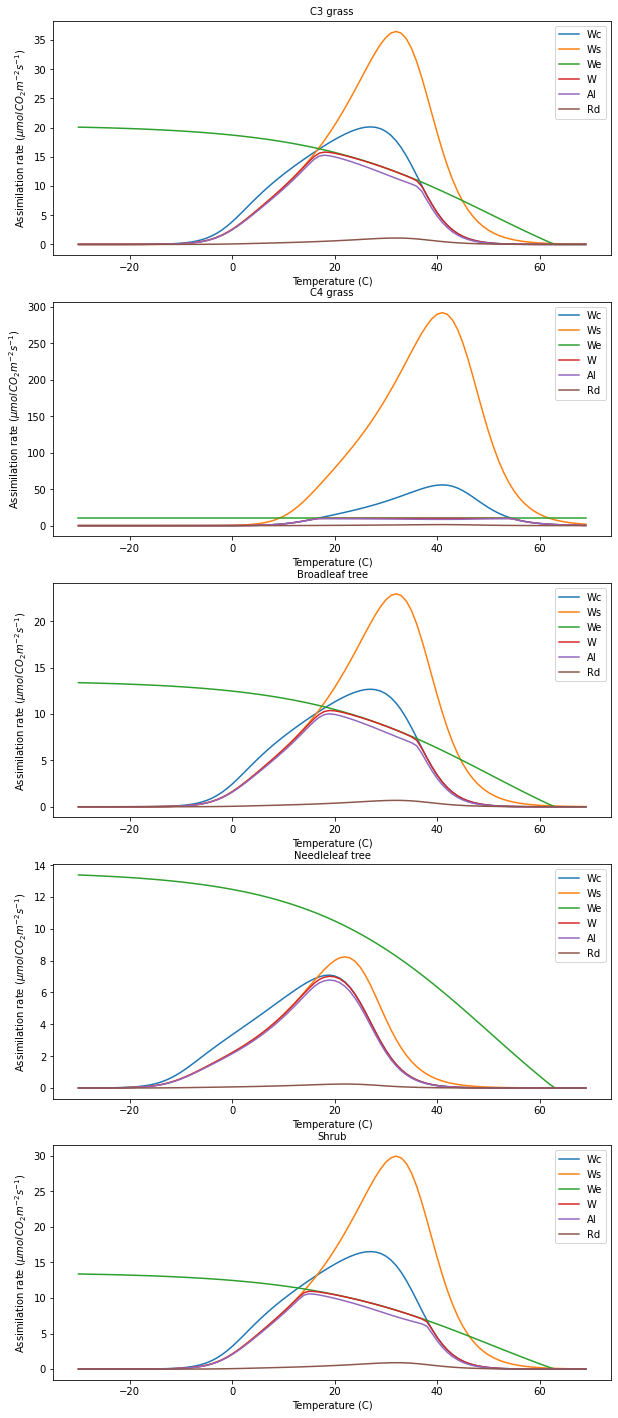

In [3]:
# list of all pfts
pfts = ['C3 grass','C4 grass',\
            'Broadleaf tree','Needleleaf tree','Shrub']

plotter = {
    'n_subplots' : len(pfts),  # number of sub-plots
    'name'       : 'default',  # plot name
    'ymax'        : None      # max value for y set
}

# store the data for each PFT in a dictionary
output = {}
# loop over pfts
for pft in pfts:
    output[pft],plotter = do_photosynthesis(pft_type=pft,plotter=plotter)

We can access the data generated from the variable `photo`, e.g. for `We`:

In [4]:
print(output['C3 grass'].We * 1e6)
# or eg  maximum value using .max()
print(f"max We value for C3 grass {output['C3 grass'].We.max() * 1e6} umolCO2m-2s-1")

[20.07264114 20.05392673 20.03415539 20.01326894 19.99120619 19.96790277
 19.94329102 19.91729986 19.88985457 19.86087674 19.83028405 19.79799013
 19.76390443 19.72793204 19.68997355 19.64992489 19.60767719 19.56311662
 19.51612425 19.46657594 19.41434218 19.35928799 19.30127283 19.24015047
 19.17576897 19.10797059 19.03659177 18.96146314 18.88240955 18.79925011
 18.71179831 18.61986213 18.52324429 18.42174242 18.31514942 18.20325376
 18.08583995 17.96268901 17.83357906 17.69828597 17.55658409 17.40824711
 17.25304897 17.0907649  16.92117254 16.74405318 16.55919312 16.36638508
 16.16542976 15.9561375  15.73833    15.51184214 15.2765239  15.03224229
 14.77888341 14.51635445 14.24458577 13.96353297 13.67317884 13.37353537
 13.06464561 12.74658537 12.41946486 12.08343005 11.7386639  11.38538724
 11.02385948 10.65437893 10.27728282  9.89294692  9.50178488  9.10424706
  8.70081907  8.29201989  7.87839955  7.46053652  7.03903474  6.61452024
  6.18763765  5.75904628  5.32941618  4.89942389  4

### Experiment 1: What controls leaf-level photosynthesis?

#### Exercise

**Light-limiting assimilation**

We repeat Table 2 from [Clark et al., 2011](http://www.geosci-model-dev.net/4/701/2011/gmd-4-701-2011.html) for convenience:

![Clark et al., 2011: figure 2](images/jules-fig2.jpg)



From the data in this table and your understanding of the controls on photosynthesis in the model, answer the following questions and confirm your answer by running the model.

* which PFT has the highest values of `We`, and why?
* How does this change with increasing `ipar`?
* When ipar is the limiting factor, how does assimilation change when ipar increases by a factor of k?
* For C3 grasses, what are the limiting factors over the temperatures modelled for ipar=200?
* For C3 grasses, what are the limiting factors over the temperatures modelled for ipar=400?
* For C4 grasses, what are the limiting factors over the temperatures modelled? 

In [5]:
#### ANSWER

msg = f'''
which PFT has the highest values of We, and why?

From the notes, product of the quantum efficiency alpha, 
the PAR absorption rate (ipar) and the leaf absorptance 
(1 - omega, where omega is the leaf single scattering albedo).

So, for given ipar, it is controlled by the product of
alpha and (1 - omega).

The C3 plants have the same value of omega here (0.15)
so 1 - omega = 0.85. For C4, this is 0.83.

C3 grasses have the highest value of alpha (0.12).

So, 
For C3 max, we have alpha * (1 - omega) = 0.85 * 0.12 = {0.85 * 0.12}
For C4    , we have alpha * (1 - omega) = 0.83 * 0.06 = {0.83 * 0.06}

so, C3 grasses should have the highest We.

The other C3 plants should have the same We curves.

We can demonstrate this:

Maximum We for each PFT for default CO2 and ipar
'''

print(msg)

# list of all pfts
pfts = ['C3 grass','C4 grass',\
            'Broadleaf tree','Needleleaf tree','Shrub']
# store the data for each PFT
output = {}
# loop over pfts
for pft in pfts:
    output[pft],plotter = do_photosynthesis(ipar=200,pft_type=pft)
    print(pft,output[pft].We.max() * 1e6,'umolCO2m-2s-1')
    
    


which PFT has the highest values of We, and why?

From the notes, product of the quantum efficiency alpha, 
the PAR absorption rate (ipar) and the leaf absorptance 
(1 - omega, where omega is the leaf single scattering albedo).

So, for given ipar, it is controlled by the product of
alpha and (1 - omega).

The C3 plants have the same value of omega here (0.15)
so 1 - omega = 0.85. For C4, this is 0.83.

C3 grasses have the highest value of alpha (0.12).

So, 
For C3 max, we have alpha * (1 - omega) = 0.85 * 0.12 = 0.102
For C4    , we have alpha * (1 - omega) = 0.83 * 0.06 = 0.0498

so, C3 grasses should have the highest We.

The other C3 plants should have the same We curves.

We can demonstrate this:

Maximum We for each PFT for default CO2 and ipar

C3 grass 20.07264113525945 umolCO2m-2s-1
C4 grass 9.959999999999997 umolCO2m-2s-1
Broadleaf tree 13.381760756839634 umolCO2m-2s-1
Needleleaf tree 13.381760756839634 umolCO2m-2s-1
Shrub 13.381760756839634 umolCO2m-2s-1


In [6]:
#### ANSWER
msg = '''
How does this change with increasing ipar?

It scales with ipar, so increasing ipar increases We

'''
print(msg)
output = {}
pfts = ['C3 grass','C4 grass']
for pft in pfts:
    output[pft],plotter = do_photosynthesis(pft_type=pft,ipar=200.)
    print(pft,'ipar=200',output[pft].We.max() * 1e6,'umolCO2m-2s-1')
    output[pft],plotter = do_photosynthesis(pft_type=pft,ipar=400.)
    print(pft,'ipar=400',output[pft].We.max() * 1e6,'umolCO2m-2s-1')


How does this change with increasing ipar?

It scales with ipar, so increasing ipar increases We


C3 grass ipar=200 20.07264113525945 umolCO2m-2s-1
C3 grass ipar=400 40.1452822705189 umolCO2m-2s-1
C4 grass ipar=200 9.959999999999997 umolCO2m-2s-1
C4 grass ipar=400 19.919999999999995 umolCO2m-2s-1


In [7]:
#### ANSWER

msg = '''
When ipar is the limiting factor, how does assimilation change 
when ipar increases by a factor of k?

This is almost the same question as above:

When ipar is the limiting factor (for all cases) it scales
directly with the value of ipar -- so increasing ipar by a factor of 
k will increase assimilation by that same factor.
'''
print(msg)


When ipar is the limiting factor, how does assimilation change 
when ipar increases by a factor of k?

This is almost the same question as above:

When ipar is the limiting factor (for all cases) it scales
directly with the value of ipar -- so increasing ipar by a factor of 
k will increase assimilation by that same factor.



>>> Saved result in photter_default.png

With ipar=200 and co2_ppmv=390, we have the same graph we saw earlier.
The limiting factors are Ws up to around 17 C 
(close to We value), then We to around 36 C
then Wc. At moderate temperatures then, and low ipar, 
light is the main limiting factor. At lower temperatures
it is transport-limited (almost the same as carboxylation)
and at higher tempertures it is limited by carboxylation.



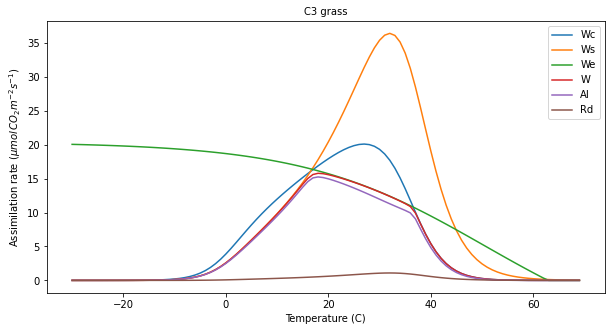

In [8]:
### ANSWER
msg = '''
For C3 grasses, what are the limiting factors over the temperatures modelled for ipar=200?
'''

# list of all pfts
pfts = ['C3 grass']

plotter = {
    'n_subplots' : len(pfts),       # number of sub-plots
    'name'       : 'default',  # plot name
    'ymax'        : None      # max value for y set
}

# store the data for each PFT
output = {}
# loop over pfts
for pft in pfts:
    output[pft],plotter = do_photosynthesis(ipar=200,pft_type=pft,plotter=plotter)
    
msg = '''
With ipar=200 and co2_ppmv=390, we have the same graph we saw earlier.
The limiting factors are Ws up to around 17 C 
(close to We value), then We to around 36 C
then Wc. At moderate temperatures then, and low ipar, 
light is the main limiting factor. At lower temperatures
it is transport-limited (almost the same as carboxylation)
and at higher tempertures it is limited by carboxylation.
'''
print(msg)

>>> Saved result in photter_default.png

With ipar=400 and co2_ppmv=390, we have removed the
light limitation. The main shape follows closely
that of Wc, though up to around 17 C it is
actually Ws that is limiting here.



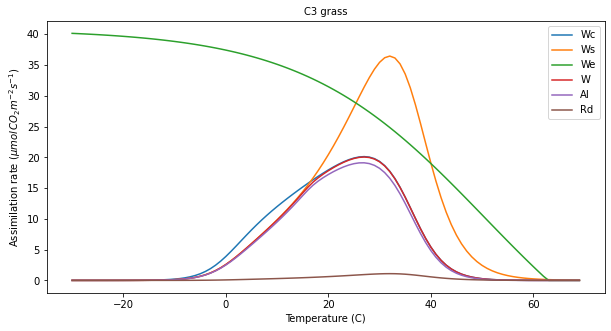

In [9]:
### ANSWER
msg = '''
For C3 grasses, what are the limiting factors over the temperatures modelled for ipar=400?
'''

# list of all pfts
pfts = ['C3 grass']

plotter = {
    'n_subplots' : len(pfts),       # number of sub-plots
    'name'       : 'default',  # plot name
    'ymax'        : None      # max value for y set
}

# store the data for each PFT
output = {}
# loop over pfts
for pft in pfts:
    output[pft],plotter = do_photosynthesis(ipar=400,pft_type=pft,plotter=plotter)
    
msg = '''
With ipar=400 and co2_ppmv=390, we have removed the
light limitation. The main shape follows closely
that of Wc, though up to around 17 C it is
actually Ws that is limiting here.
'''
print(msg)

>>> Saved result in photter_default.png

With ipar=200 and co2_ppmv=390, we have the same graph we saw earlier.
The limiting factors are Wc up to around 17 C and after 36 C. 
For moderate temperatures, it is light limited. The light-limited rate
defines the maximum assimilation rate.



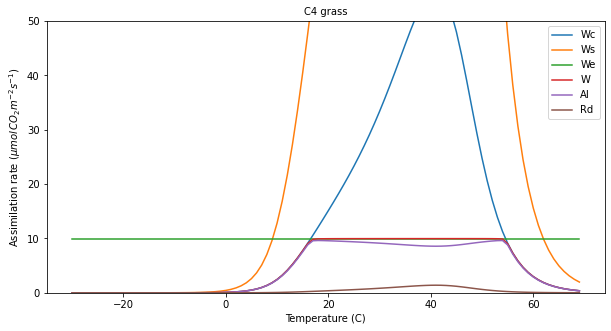

In [10]:
### ANSWER
msg = '''
For C4 grasses, what are the limiting factors over the temperatures modelled?
'''

# list of all pfts
pfts = ['C4 grass']

# set ymax here to be able to see the plots
plotter = {
    'n_subplots' : len(pfts),       # number of sub-plots
    'name'       : 'default',  # plot name
    'ymax'        : 50      # max value for y set
}

# store the data for each PFT
output = {}
# loop over pfts
for pft in pfts:
    output[pft],plotter = do_photosynthesis(ipar=200,pft_type=pft,plotter=plotter)
    
msg = '''
With ipar=200 and co2_ppmv=390, we have the same graph we saw earlier.
The limiting factors are Wc up to around 17 C and after 36 C. 
For moderate temperatures, it is light limited. The light-limited rate
defines the maximum assimilation rate.
'''
print(msg)

>>> Saved result in photter_default.png

As we increase ipar, we reduce the temperature range at which 
light limitation kicks in, and increase the maximum rate
proportionately by the proportionate increase in ipar. 



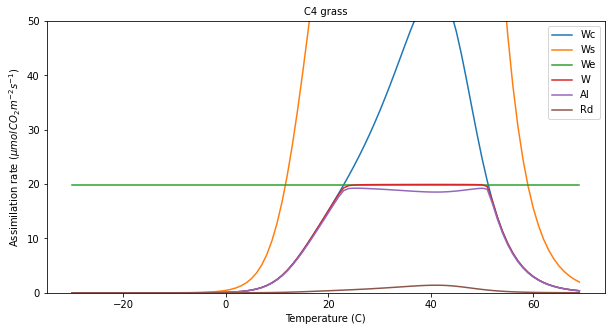

In [11]:
#### ANSWER

# list of all pfts
pfts = ['C4 grass']

# store the data for each PFT
output = {}
# set ymax here to be able to see the plots
plotter = {
    'n_subplots' : len(pfts),       # number of sub-plots
    'name'       : 'default',  # plot name
    'ymax'        : 50      # max value for y set
}

# loop over pfts
for pft in pfts:
    output[pft],plotter = do_photosynthesis(ipar=400,pft_type=pft,plotter=plotter)
    
msg = '''
As we increase ipar, we reduce the temperature range at which 
light limitation kicks in, and increase the maximum rate
proportionately by the proportionate increase in ipar. 
'''
print(msg)

## Incident PAR

Solar radiation drives the Earth system and strongly impacts the terrestrial Carbon cylcle. 

We will next include a model of solar radiation to examine diurnal and seasonal variations. We use the [PyEphem](http://rhodesmill.org/pyephem/) Python package, which allows us to calculate the position of the sun with respect to an observer on Earth. So we need time as well as longitude and latitude.

Before we do that, let's make sure we understand the main factors causing these variations.

We will use the `solar_model` method that gives time axis in units of Julian days, as well as the solar zenith angle (in degrees), the Earth-Sun distance, as well as the solar radiation in mol(photons)/m^2s.


In [12]:
help(solar_model)

Help on function solar_model in module geog0133.solar:

solar_model(secs, mins, hours, days, months, years, lats, longs, julian_offset='2000/1/1')
    A function that calculates the solar zenith angle (sza, in
    degrees), the Earth-Sun distance (in AU), and the instantaneous 
    downwelling solar radiation in mol(photons) per square meter per
    second for a set of time(s) and geographical locations.



A small aside on defining dates. We will be defining the date by the day of year (`doy`) when we run these exercises, but the code we are using requires a definition of date as days and month. To convert between these in Python, we use the `datetime` module to specify the 1st of January for the given year in the variable `datetime_object`, then add on the `doy` (actually `doy-1` because when `doy` is 1 we mean January 1st). We then specify `day` `month` and `year` as `datetime_object.day`,`datetime_object.month`,`datetime_object.year`

In [13]:
# set a date by year and doy
year = 2020
doy = 32

# convert to datetime object
datetime_object = datetime(year,1,1)+timedelta(doy-1)
# extract day, month and year
datetime_object.day,datetime_object.month,datetime_object.year

(1, 2, 2020)

Orbital mechanics impose a variation in the Earth-Sun distance over the year. This is typically expressed in [Astronomical Units](https://en.wikipedia.org/wiki/Astronomical_unit) (AU), so relative to the mean Earth-Sun distance.

The Exo-atmospheric solar radiation E0 ($W/m^2$) (total shortwave radiation) is defined as:

$$
E0 = \frac{G_{sc}}{r^2}
$$

where $G_{sc}$ is the Solar Constant (around 1361 $W/m^2$) and $r$ is the Earth-Sun distance in AU (inverse-squared law). 

Around half of the SW energy is in the PAR region, so to calculate PAR, we scale by 0.5. 

The energy content of PAR quanta is around $220.e-3$  $MJmol^{-1}$, so the top of atmosphere (TOA) PAR solar radiation is $\frac{E0}{2 \times 220.e-3}$ $mol/{m^2s}$, so 3093 = $mol/{m^2s}$ at 1 AU.

We can use `solar_model` to calculate this distance and ipar variation, and visualise the orbit:

In [14]:
year=2020
doys = np.arange(1,366)
dts = [datetime(year,1,1) + timedelta(int(doy)-1) for doy in doys]
# solar distance in AU
print()
distance = np.array([solar_model(0.,[0],[12],\
            dt.day,dt.month,dt.year,0,0)[2] for dt in dts]).ravel()
swrad    = np.array([solar_model(0.,[0],[12],\
            dt.day,dt.month,dt.year,0,0)[3] for dt in dts]).ravel()
print(f'distance range : {distance.min():6.4f} to {distance.max():6.4f} AU')
print(f'swrad    range : {swrad.min():6.0f} to {swrad.max():6.0f} mol/ (m^2 s)')


distance range : 0.9832 to 1.0167 AU
swrad    range :   5985 to   6400 mol/ (m^2 s)


![Seasons](https://upload.wikimedia.org/wikipedia/commons/f/f0/Seasons1.svg)

![Earth-Sun distance](earth.gif)



This [animation](geog0133/sunplot.py) shows the variation in Earth-Sun distance. The eccentricity of the Earth orbit is **really quite low** (0.0167) (a circle at 1 AU is shown as a dashed line) so the solar radiation varies by around 7% over the year. The ipar variation is illustrated by the size of the Sun in this animation, the diameter of which is made proportional to ipar but exxagerated to the 4th power for illustration. 

#### Exercise

* At what time of year is PAR radiation incident on Earth the highest?
* Why is this so?

In [15]:
#### ANSWERS
msg = '''
At what time of year is PAR radiation incident on Earth the highest?
Why is this so?

The periapsis (closest distance between the Sun and the Earth) 
occurs in Northern Latitude winter, 
so PAR incident on the Earth is *highest* in Northern Latitude winter.
'''
print(msg)


At what time of year is PAR radiation incident on Earth the highest?
Why is this so?

The periapsis (closest distance between the Sun and the Earth) 
occurs in Northern Latitude winter, 
so PAR incident on the Earth is *highest* in Northern Latitude winter.



### The seasons

We need to take account of this annual (7%) variation when we model PAR interception by vegetation, but it is not the strongest cause of variation over the year. Solar radiation is projected onto the Earth surface. We can express this projection by the cosine of the solar zenith angle. When the Sun is directly overhead (zenith angle zero degrees), then the projection is 1. As the zenith angle increases, the projected radiation decreases until it is 0 at a zenith angle of 90 degrees.


The seasons are not directly related to the Earth-Sun distance variations then. They arise in the main because the Earth is tilted on its axis by 23.5 degrees (obliquity).

![](https://www.nasa.gov/sites/default/files/thumbnails/image/axis_.png)

We will use `solar_model`  to calculate the amount of incoming PAR. To do this, we assume:

* that PAR is around 50% of total downwelling (shortwave) radiation,
* that the optical thickness ($\tau$) of the atmosphere in the PAR region is around 0.2
* and that we multiply by all this by $\cos(sza)$ to project on to a flat surface.

Let's look at how that varies over the year, for some different latitudes.

[80, 172, 264, 355]


(0.0, 365.0)

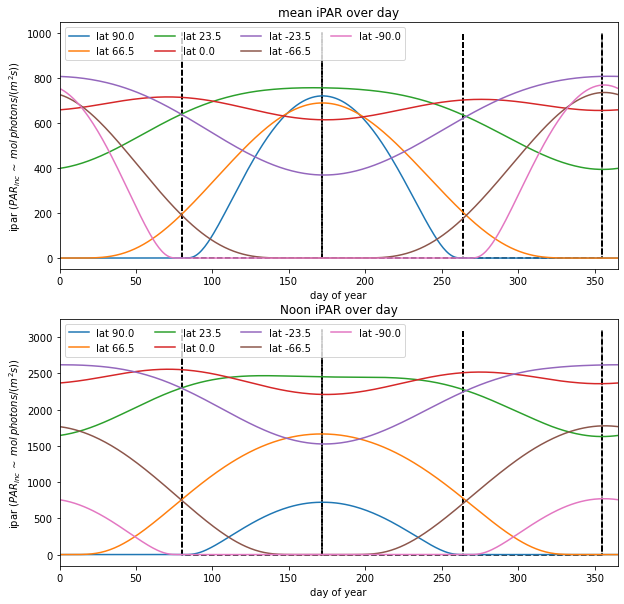

In [16]:
year=2020
# plot solstices and equinox
es = [datetime(year,3,21),datetime(year,6,21),datetime(year,9,21),datetime(year,12,21)]
des = [(e - datetime(year,1,1)).days for e in es]
print(des)

doys = np.arange(1,366)
dts = [datetime(year,1,1) + timedelta(int(doy)-1) for doy in doys]


tau = 0.2
parprop = 0.5 

latitudes = [90,90-23.5,23.5,0,-23.5,23.5-90,-90]
fig,axs = plt.subplots(2,1,figsize=(10,10))

# equinox and solstice as dashed lines
axs[0].plot(np.array([des]*3).T.ravel(),np.array([[0]*4,[1000]*4,[0]*4]).T.ravel(),'k--')
axs[1].plot(np.array([des]*3).T.ravel(),np.array([[0]*4,[3100]*4,[0]*4]).T.ravel(),'k--')

for i,lat in enumerate(latitudes):
    swrad  = np.array([solar_model(0.,[0,30],np.arange(25),dt.day,dt.month,dt.year,lat,0)[3] for dt in dts])
    sza  = np.array([solar_model(0.,[0,30],np.arange(25),dt.day,dt.month,dt.year,lat,0)[1] for dt in dts])
    mu = np.cos(np.deg2rad(sza))
    ipar = (swrad* mu * np.exp(-tau/mu) * parprop)
    ipar[ipar<0] = 0
    axs[0].plot(doys,ipar.mean(axis=1),label=f'lat {lat:.1f}')
    axs[1].plot(doys,ipar.max(axis=1),label=f'lat {lat:.1f}')
     
axs[0].legend(loc='best',ncol=4)
axs[0].set_title(f'mean iPAR over day')
axs[0].set_xlabel('day of year')
axs[0].set_ylabel('ipar ($PAR_{inc}\,\sim$ $mol\, photons/ (m^2 s)$)')
axs[0].set_xlim(0,doys[-1])
axs[1].legend(loc='best',ncol=4)
axs[1].set_title(f'Noon iPAR over day')
axs[1].set_xlabel('day of year')
axs[1].set_ylabel('ipar ($PAR_{inc}\,\sim$ $mol\, photons/ (m^2 s)$)')
axs[1].set_xlim(0,doys[-1])

Now, lets look at variation over the day, for some selected days:

[80, 172, 264, 355]


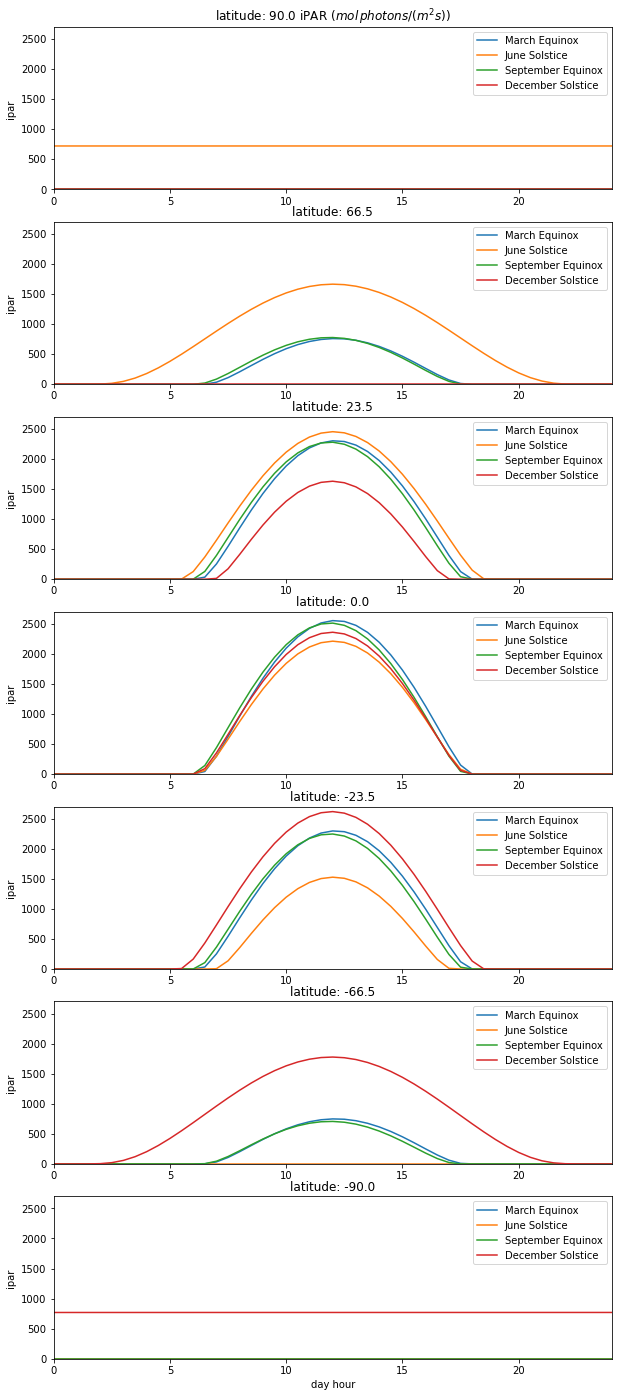

In [17]:
tau=0.2
parprop=0.5
year=2020

# equinox and solstice
es = [datetime(year,3,21),datetime(year,6,21),datetime(year,9,21),datetime(year,12,21)]
des = [(e - datetime(year,1,1)).days for e in es]
print(des)

latitudes = [90,90-23.5,23.5,0,-23.5,23.5-90,-90]
fig,axs = plt.subplots(len(latitudes),1,figsize=(10,3.5*len(latitudes)))

legends = ['March Equinox','June Solstice','September Equinox','December Solstice']

for i,lat in enumerate(latitudes):
    axs[i].set_title(f'latitude: {lat:.1f}')
    axs[i].set_ylabel('ipar ')
    axs[i].set_xlim(0,24)
    axs[i].set_ylim(0,2700)
    for j,doy in enumerate(des):
        # datetime
        dt = datetime(year,1,1) + timedelta(doy-1)
        # call solar_model
        jd, sza, distance, solar_radiation = solar_model(
                0.,np.array([0.,30]),np.arange(25),dt.day,dt.month,dt.year,lat, 0)
        mu = np.cos(np.deg2rad(sza))
        s = (solar_radiation*parprop * np.exp(-tau/mu) * mu)
        axs[i].plot((jd-jd[0])*24,s,label=legends[j])
    axs[i].legend(loc='best')
    
axs[0].set_title(f'latitude: {latitudes[0]:.1f} iPAR ($mol\, photons/ (m^2 s)$)')
_=axs[-1].set_xlabel('day hour')

#### Exercise

* Describe and explain the patterns of iPAR as a function of day of year and latitude.
* Comment on the likely reality of these patterns.

## Weather generation

To run our photosynthesis model, we need to know the temperature as well as the IPAR. That is rather complicated to model, so we will use observational data to drive the model. We choose the interpolated [CRU climate dataset](https://sites.uea.ac.uk/cru/data) for this. 

You can select this using the [`getCRU()`](geog0133/cru.py) function for a given latitude, longitude and year (2011 to 2019 inclusive here). This gives you access to **monthly** minimum and maximum temperatures, `f['tmn']` and `f['tmx']` respectively, as well as cloud cover percentage `f['cld']`. The dataset is for the land surface only. If you specify somewhere in the ocean, you will get an interpolated result.

### Scaling iPAR by cloud cover

We will use the cloud percentage to reduce iPAR, by setting a reduction factor by 1/3 (to a value of 2/3) on cloudy days (when `f['cld']` is 100) and 1 when there is no cloud.

    scale = 1 - f['cld']/300

In [18]:
# ANSWER
msg = '''
Explain the patterns of modelled iPAR as a function of day of year
and latitude.

We have plotted iPAR as a function of DOY for various latitudes.

90 and -90 are the poles and only receive radiation during half of
the year, bounded by the spring and autumn equinox (dashed lines).
The peak occurs at the solstice (24 hours of daylight). 

66.5 and -65.5 are the polar circles. At and above these latitides 
there is no iPAR (0 hours of daylight) in the winter (summer) 
equinox for the Arctic (Antarctic) but 24 hours of daylight at 
solstice (they peak at one solstice and have a minimum at the other).

23.5 (-23.5) are the topics. These are significant because they 
have the sun directly overhead (sza = 0) at noon on the solstice. 

0 degrees is the equator. The sun is directly overhead
at noon on the equinox. We also see that there is the smallest variation
in iPAR, according to this model.

The peak magnitide of noon iPAR varies considerably with latitude, 
but there is surprisingly little variation in the peak *mean* iPAR with
latitude. This is because of variations in daylength.

The explanation for all of this lies in the seasonal behaviour 
of the solar zenith angle (you should expand on this in your answer!).
'''
print(msg)


Explain the patterns of modelled iPAR as a function of day of year
and latitude.

We have plotted iPAR as a function of DOY for various latitudes.

90 and -90 are the poles and only receive radiation during half of
the year, bounded by the spring and autumn equinox (dashed lines).
The peak occurs at the solstice (24 hours of daylight). 

66.5 and -65.5 are the polar circles. At and above these latitides 
there is no iPAR (0 hours of daylight) in the winter (summer) 
equinox for the Arctic (Antarctic) but 24 hours of daylight at 
solstice (they peak at one solstice and have a minimum at the other).

23.5 (-23.5) are the topics. These are significant because they 
have the sun directly overhead (sza = 0) at noon on the solstice. 

0 degrees is the equator. The sun is directly overhead
at noon on the equinox. We also see that there is the smallest variation
in iPAR, according to this model.

The peak magnitide of noon iPAR varies considerably with latitude, 
but there is surprisingly lit

In [19]:
msg = '''
Comment on the likely reality of these patterns.

These plots take no account of several important factors:

* altitude (less atmospheric path for attenuation) so
  the radiation will be higher at altitude. Also, the
  spectral nature of the SW radiation will vary with
  altitude, so the proportion of PAR may also vary.
* cloud cover: In the tropics in particular, extensive
  cloud cover will lower the irradiance at the surface.
* slope: the Earth here is assumed flat, relative to the
  geoid, but the local terrain slope and aspect will strongly
  affect local conditions (consider the projection term).
* Earth curvature: the airmass here in the attenuation term
  is considered 1/cos(sza). That is a good approximation 
  up to around 70 degrees. Beyond that, Earth curvature 
  effects and refraction should normally be accounted for.
  However, since the iPAR is low under those conditions,
  it is often ignored. It may be significant towards the Poles.
'''
print(msg)


Comment on the likely reality of these patterns.

These plots take no account of several important factors:

* altitude (less atmospheric path for attenuation) so
  the radiation will be higher at altitude. Also, the
  spectral nature of the SW radiation will vary with
  altitude, so the proportion of PAR may also vary.
* cloud cover: In the tropics in particular, extensive
  cloud cover will lower the irradiance at the surface.
* slope: the Earth here is assumed flat, relative to the
  geoid, but the local terrain slope and aspect will strongly
  affect local conditions (consider the projection term).
* Earth curvature: the airmass here in the attenuation term
  is considered 1/cos(sza). That is a good approximation 
  up to around 70 degrees. Beyond that, Earth curvature 
  effects and refraction should normally be accounted for.
  However, since the iPAR is low under those conditions,
  it is often ignored. It may be significant towards the Poles.



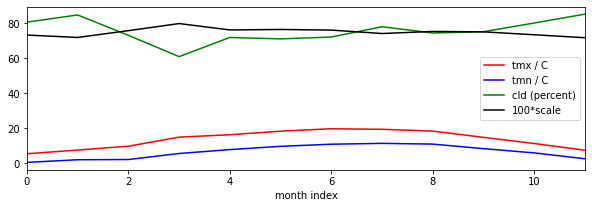

In [20]:
from geog0133.cru import getCRU

f = getCRU(2019,longitude=0,latitude=56)
tmx = f['tmx']
tmn = f['tmn']
cld = f['cld']

plt.figure(figsize=(10,3))
plt.plot(tmx,'r',label='tmx / C')
plt.plot(tmn,'b',label='tmn / C')
plt.plot(cld,'g',label='cld (percent)')
# irradiance reduced by 1/3  on cloudy days
plt.plot(100*(1-cld/300.),'k',label='100*scale')
plt.xlabel('month index')
plt.legend(loc='best')
_=plt.xlim(0,11)

### Synthesizing diurnal temperature

Since we only have monthly minimum and maximum temperature, we need to be able to estimate the diurnal variation of temperature from these. We can broadly achieve this by scaling by normalised IPAR. However, there will be a time lag between greater radiation input and temperature caused by inertia in the system. We can mimic this effect with a one-sided smoothing filter that 'smears' the temperature forward in time. The degree of smearing is controlled by the filter width parameter `f` (e.g. 8 hours). This is achieved in the function `splurge`:

In [21]:
def splurge(ipar,f=8.0):
    '''
    Spread the quantity ipar forward in time
    using a 1-sided exponential filter of width 
    f * 2.
    
    Arguments:
        ipar: array of 1/2 hourly time step ipar values 
              (length 48)
              
    Keyword:
        f : filter characteristic width. Filter is
            exp(-x/(f*2))
            
    Return:
        ipar_ : normalised, splurged ipar array
    '''
    if f == 0:
        return (ipar-ipar.min())/(ipar.max()-ipar.min())
    # build filter over large extent
    nrf_x_large = np.arange(-100,100)
    # filter function f * 2 as f is in hours
    # but data in 1/2 hour steps
    nrf_large = np.exp(-nrf_x_large/(f*2))    
    # 1-sided filter
    nrf_large[nrf_x_large<0] = 0
    nrf_large /= nrf_large.sum()
    ipar_ = scipy.ndimage.filters.convolve1d(ipar, nrf_large,mode='wrap')
    return (ipar_-ipar_.min())/(ipar_.max()-ipar_.min())


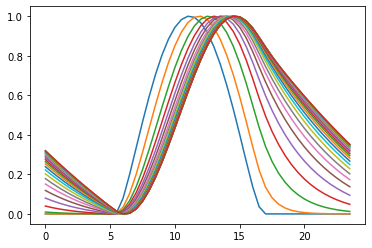

In [22]:
# Calculate solar position over a day, every 30 mins
year=2020
doy =80
latitude, longitude = 51,0
dt = datetime(year,1,1) + timedelta(doy-1)

# solar radiation
jd, sza, distance, solar_radiation = solar_model(
    0.,np.array([0.,30.]),np.arange(1,25),dt.day,dt.month,dt.year,
    latitude, longitude)

hour = (jd-jd[0])*24 
# cosine
mu = np.cos(np.deg2rad(sza))
ipar = solar_radiation* parprop * np.exp(-tau/mu) * mu

# smear ipar
# filter length f (hours)
f = 1.0 # hours 
for f in np.arange(0,24):
    plt.plot(hour,splurge(ipar,f=f))

A value of `f` of `8` give a 2 hour delay in the peak of around 2 hours which is a reasonable average value we can use to mimic temperature variations. A simple model of diurnal temperature variatioins then is to simply scale this by the monthly temperature minimum and maximum values:

    Tc = ipar_*(Tmax-Tmin)+Tmin
    
One problem with this approach is that the variation we achieve in temperature (and IPAR) is significantly less than in reality. This can reduce the apparent variation in CO2 fluxes. In practice, when modellers attempt to estimate instantaneous (or short time-integral) values from means, they insert additional random variation to match some other sets of observed statistical variation (including correlations). We ignore that here, for simplicity.

In [23]:
import numpy as np
from datetime import datetime
from datetime import timedelta

def radiation(latitude,longitude,doy,
              tau=0.2,parprop=0.5,year=2020,
              Tmin=5.0,Tmax=30.0,f=8.0):
    '''
    Simple model of solar radiation making call 
    to solar_model(), calculating modelled
    ipar 
    
    Arguments:
    latitude : latitude (degrees)
    longitude: longitude (degrees)
    doy:  day of year (integer)
    
    Keywords:
    
    tau:     optical thickness (0.2 default)
    parprop: proportion of solar radiation in PAR
    Tmin:    min temperature (C) 20.0 default
    Tmax:    max temperature (C) 30.0 default
    year:    int 2020 default
    f:       Temperature smearing function characteristic
             length (hours)
    
    '''
    # Calculate solar position over a day, every 30 mins
    # for somewhere like London (latitude 51N, Longitude=0)
    dt = datetime(year,1,1) + timedelta(doy-1)

    jd, sza, distance, solar_radiation = solar_model(
        0.,np.array([0.,30.]),np.arange(25),dt.day,dt.month,dt.year,
        latitude, longitude,julian_offset=f'{year}/1/1')
    mu = np.cos(np.deg2rad(sza))
    
    n = mu.shape[0]

    ipar = solar_radiation* parprop * np.exp(-tau/mu) * mu  # u mol(photons) / (m^2 s)
    fd = getCRU(2019,longitude=longitude,latitude=latitude)
    Tmax = fd['tmx'][dt.month-1]
    Tmin = fd['tmn'][dt.month-1]
    cld = fd['cld'][dt.month-1]
    scale = (1-cld/300.)
    print(f'Tmin {Tmin:.2f} Tmax {Tmax:.2f} Cloud {cld:.2f} Scale {scale:.2f}')
    # reduce irradiance by 1/3 on cloudy day
    ipar = ipar * scale
    # smear ipar
    ipar_ = splurge(ipar,f=f)
    # normalise
    Tc = ipar_*(Tmax-Tmin)+Tmin
    #Tc = (Tc-Tc.min())
    #Tc = Tc/Tc.max()
    #Tc = (Tc*(Tmax-Tmin) + (Tmin))
    return jd-jd[0],ipar,Tc


We can now run the driver synthesis for some given latitude/longitude and time period:

Tmin 5.50 Tmax 11.60 Cloud 71.30 Scale 0.76
Tmin 12.20 Tmax 19.90 Cloud 64.20 Scale 0.79
Tmin 11.90 Tmax 19.20 Cloud 63.10 Scale 0.79
Tmin 5.20 Tmax 10.00 Cloud 81.60 Scale 0.73


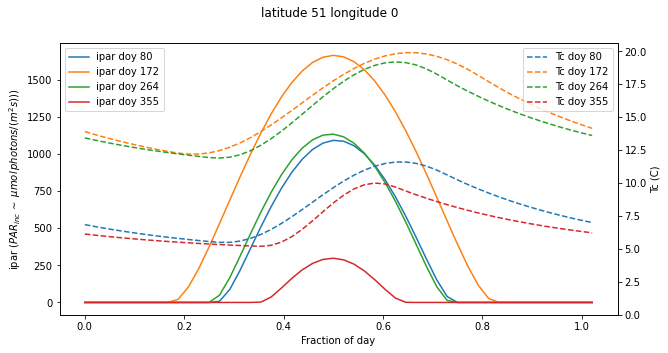

In [24]:
tau=0.2
parprop=0.5
year=2020

latitude = 51
longitude = 0

fig,ax=plt.subplots(1,1,figsize=(10,5))
ax2 = ax.twinx() 

# loop over solstice and equinox doys
for doy in [80,172,264,355]:
    jd,ipar,Tc = radiation(latitude,longitude,doy)
    
    ax.plot(jd-jd[0],ipar,label=f'ipar doy {doy}')
    ax2.plot(jd-jd[0],Tc,'--',label=f'Tc doy {doy}')
    
# plotting refinements
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_ylabel('ipar ($PAR_{inc}\,\sim$ $\mu mol\, photons/ (m^2 s))$)')
ax2.set_ylabel('Tc (C)')
ax.set_xlabel("Fraction of day")
ax2.set_ylim(0,None)
_=fig.suptitle(f"latitude {latitude} longitude {longitude}")

## leaf-scale photosynthesis

Now we have some appropriate weather data, we can run the photosynthesis model for what should be typical conditions in space and time.

Tmin 5.50 Tmax 11.60 Cloud 71.30 Scale 0.76
Tmin 12.20 Tmax 19.90 Cloud 64.20 Scale 0.79
Tmin 11.90 Tmax 19.20 Cloud 63.10 Scale 0.79
Tmin 5.20 Tmax 10.00 Cloud 81.60 Scale 0.73


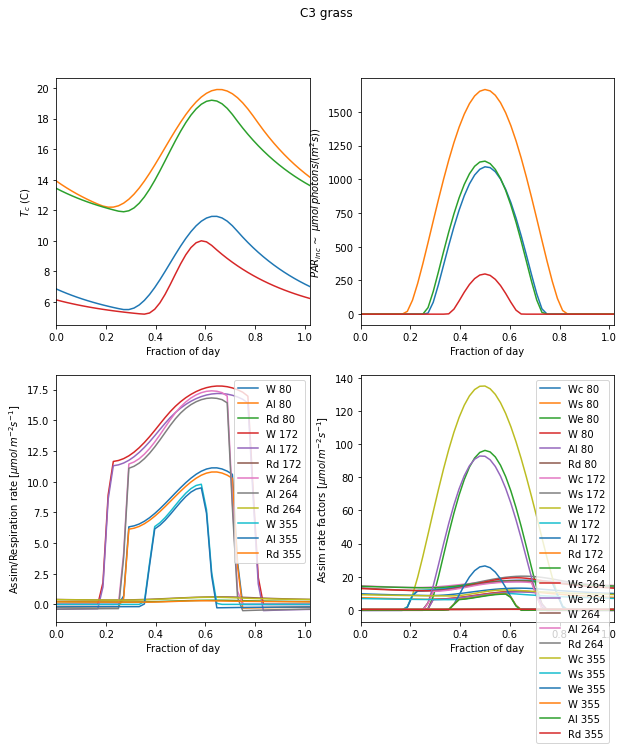

In [26]:
## year=2020

latitude = 51
longitude = 0

pft = "C3 grass"

doys = [80,172,264,355]
fig = None
axs = None

for i,doy in enumerate(doys):
    jd,ipar,Tc = radiation(latitude,longitude,doy)


    p = do_photosynthesis(n=len(ipar), pft_type=pft,Tc=Tc, \
                          ipar=ipar,co2_ppmv=390,\
                          x=ipar,plotter=None)[0]

    fig,axs = day_plot(jd,ipar,Tc,p,title=pft,info=str(doy),\
                       fig=fig,axs=axs,final=(i==len(doys)-1))

This is quite an interesting figure! If the only thing that varies over the day is the solar radiation intensity, then at this time and latitude, the (leaf) assimilation is ‘pulse’-like over the day: its is limited by light intensity at high solar zenith angles (early morning and late afternoon), then essentially flat.

Normally, the temperature will vary over the day as well, so we could e.g. assume a dependence on solar zenith angle:

Tmin 5.20 Tmax 10.00 Cloud 81.60 Scale 0.73


AttributeError: 'tuple' object has no attribute 'Al'

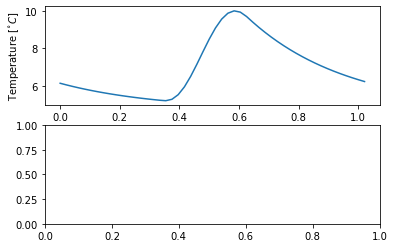

In [36]:
jd,ipar,Tc = radiation(latitude,longitude,doy)

p = do_photosynthesis(n=len(ipar),Tc=Tc, \
                  ipar=ipar,co2_ppmv=390)
sp = plt.subplot( 2, 1, 1 )
sp.plot(jd,Tc, '-')
sp.set_xlabel('Fraction of day')
sp.set_ylabel('Temperature $[^{\circ}C]$')


sp = plt.subplot( 2, 1, 2 )
sp.plot(jd,(p.Al+p.Rd)*1e6, '-')
sp.set_ylabel('Assim rate $[\mu mol\, m^{-2} s^{-1}]$')
sp.set_xlabel('Fraction of day')

In [39]:
print(p.)

<function tuple.count(value, /)>

Now we have dramatically reduced the temperature (remember, the temperature we had before was $25^{\circ}C$ constantly through the day. It now oscillates between 0 and $9^{\circ}C$) so we see a general lowering of the assimilation rate, but we also see a change in the shape.

### Exercise 2

<div class="alert alert-block alert-info">
Using codes similar to those above, explore diurnal variations in leaf assimilation rate at different latitudes and different times of year, for different PFTs (hint: once you have set this up for one example, it should be easy to run for multiple cases).

If possible, you should try to explain what the limiting factors are in each case (hint: plot terms other that `p.Al`, such as `p.Wc`, `p.Wl`, `p.We`).

It would be interesting to summarise such results by calculating the total (leaf) assimilation over the day (N.B. in the above examples, $Al$ is sampled every half hour over the day: you want a result in μmol/m2).

When performing this experiment, think about other complexities that might arise (e.g. how does the idea of phenology fit into this?)
</div>

## Canopy scale assimilation

All of the above experimentation was just at the leaf level. We have essentially looked at responses to temperature and light intensity. Of course, in a ‘real’ canopy, there will be varying amounts of leaf area, so we have to consider how to scale up the leaf-level assimilation to the canopy scale.

Although there are various ways to scale from leaf-level assimilation to the canopy level, we have only implemented what is perhaps the simplest here. This is based on the assumption that there is an acclimatisation of leaf $N$ throughout the canopy (Sellers et al., 1992) giving:
$$
V_m = V_{m0} \overline{f(L)}
$$

where $\overline{f(L)}$ is the average fraction of absorbed PAR (as opposed to instantaneous) at leaf area index (LAI) $L$, $V_{m0}$ is the ‘maximum’ (top leaf) assimilation, and $V_m$ is the canopy-scale assimilation.

Assuming a homogeneous canopy, the canopy scale PAR use efficiency $\Pi$ is:

$$
\Pi = \int_{0}^{L} \overline{f(l)}\,dl. = \left[ \frac{1-e^{-\overline{k}L}}{\overline{k}} \right] = \frac{\overline{fAPAR}}{\overline{k}}
$$


where $\overline{fAPAR}$ is the (average) fraction of absorbed PAR by the canopy and $\overline{k}$ is an effective extinction coefficient:

$$
\overline{k} = \left[ \frac{G(\mu)}{\mu} \right] {(1-\omega_l)}^{\frac{1}{2}}
$$
with $\mu$ the cosine of the (time mean) solar zenith angle (a path length term), $G(\mu)$ the ‘Ross’ or ‘$G$’-function giving the average normalised leaf projection in the direction of the (time mean) incoming radiation, and $\omega_l$ is the leaf single scattering albedo (unity minus leaf absorption) in the PAR region (see Sellers et al., 1992 for more details).

Under these assumptions then, we can calculate canopy scale photosynthesis.

$$
GPP = A_l \frac{\overline{fAPAR}}{\overline{k}}.
$$


Suppose we have an amount of leaf carbon of 0.07 $kg\,C\,m^{−2}$ and a specific leaf density of 0.025 ($kg\,C\,m^{−2}$ per unit of LAI) that is constant throughout the canopy (giving a LAI of 0.07/0.025 = 2.8), and a $G$ gunction of 0.5 (e.g. a spherical leaf angle distribution). We can model this as:

AttributeError: 'tuple' object has no attribute 'Al'

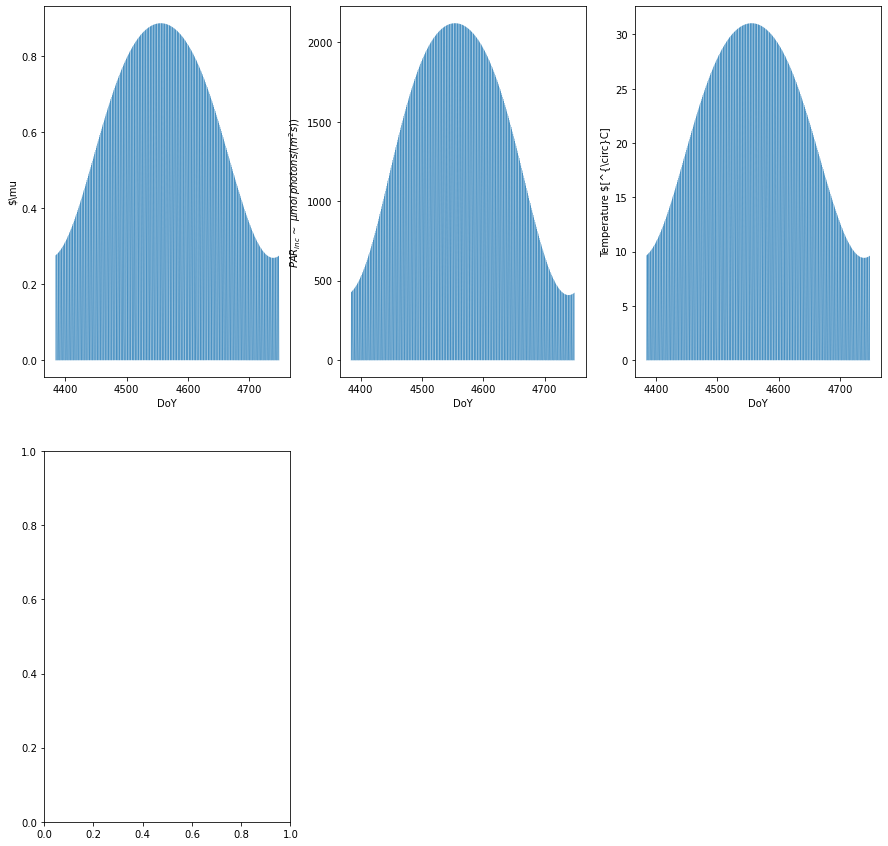

In [31]:
plt.figure(figsize=(15,15))
latitude = 51.
longitude = 0.0
jd, sza, distance, solar_radiation = solar_model(
    0.,np.array([0.,30.]),np.arange(25),
    np.arange(1, 366), 1, 2012,
    latitude, longitude)
sp = plt.subplot( 2, 3, 1 )
sp.plot(jd, np.cos(np.deg2rad(sza)), '-', lw=0.2)
sp.set_xlabel("DoY")
sp.set_ylabel('$\mu')


# assume PAR is 50% of downwelling radiation
# and atmospheric optical thickness of PAR is 0.2
# we multiply by cos(solar zenith) here to project
# onto a flat surface (a 'big leaf')

tau = 0.2
mu = np.cos(np.deg2rad(sza))
temp = 35.*mu
ipar = solar_radiation* 0.5 * np.exp(-tau/mu) * mu  # u mol(photons) / (m^2 s)
sp = plt.subplot( 2, 3, 2 )
sp.plot(jd,ipar, '-', lw=0.2)
sp.set_ylabel('$PAR_{inc}\,\sim$ $\mu mol\, photons/ (m^2 s))$')
sp.set_xlabel("DoY")

sp = plt.subplot( 2, 3, 3 )
sp.plot(jd, temp, '-', lw=0.2)
sp.set_xlabel("DoY")
sp.set_ylabel("Temperature $[^{\circ}C]")

# run the leaf level model
p = do_photosynthesis(n=len(ipar),Tc=temp,name='c',ipar=ipar,
                      co2_ppmv=390,plot=None)
sp = plt.subplot( 2, 3, 4 )
# now plot over days the leaf level response
sp.plot(jd, (p.Al + p.Rd)*1.0e6, '-', lw=0.2)
sp.set_xlabel("DoY")
sp.set_ylabel("Leaf Assim rate\n $[\mu mol\, m^{-2} s^{-1}]$")


# now we want the canopy level response

p.Lcarbon = 0.07 # kg C m-2
#self.sigmal = 0.025 # kg C m-2 per unit LAI for C3 grass
# for Needleleaf tree: 0.10
# for Broadleaf tree: 0.0375
# for others: 0.05
p.LAI = p.Lcarbon/p.sigmal

# leaf single scattering albedo
p.omega = 0.2

p.G = 0.5
p.mubar = np.mean(mu)
p.kbar = (p.G/p.mubar)*np.sqrt(1-p.omega)
p.fapar = 1 - np.exp(-p.kbar * p.LAI)
print (f'mubar = {p.mubar:.2f}')
print (f'kbar = {p.kbar:.2f}')
print (f'fapar = {p.fapar}')
# kg C m-2 s-1: conversion factor from Clark et al. 2011
p.GPP = 0.012 * (p.Al + p.Rd)* p.fapar / p.kbar

sp = plt.subplot( 2, 3, 5 )
# plot this
sp.plot(jd, p.GPP*1e6, '-', lw=0.2)
sp.set_xlabel("DoY")
sp.set_ylabel('GPP $[mg\,C m^{-2}s^{-1}]$')
plt.subplots_adjust(wspace=.5)


The Net Ecosystem Productivity needs the plant respiration terms to be subtracted from the GPP. This is typically split into mainenance and growth respiration: $R_{pm}$ and $R_{pg}$ respectively. In Jules, $R_{pg}$ is assumed to be a fixed fraction of NPP:
$$
R_{p} = R_{pm} + R_{pg}
$$

$$
R_{pg} = r_g\Pi_{G}
$$


where $\Pi_{G}$ is the GPP (the canopy scale assimilation). In Jules, $r_g$ is set to 0.25 for all PFTs (Clark et al., 2011). Leaf maintenance respiration in Jules is the (moisture-modified, through a term $\beta$ that we have not dealt with here) canopy dark respiration (i.e. canopy-scaled). Root and stem respiration are set to depend on the nitrogen concentrations of the root and stem relative to the leaf nitrogen.

Since we have not introduced stem and root biomass yet, we will assume here that leaf, root and (respiring) stem biomass ($L$, $R$ and $S$ respectively) we will assume these terms equal for the moment, since we only require their relative amounts:
$$
R_{pm}=0.012\cdot R_{dc}\left[\beta+\frac{N_r + N_s}{N_l}\right]
$$
where:

$N_x$ is the Nitrogen concentration of biomass component $x$ and the factor 0.012 converts units (see Clark et al., 2011).

$$
N_l = n_m L
$$
$$
N_r = n_m R \mu_{rl}
$$
$$
N_s = n_m S \mu_{sl}
$$

where $\mu_{xl}$ is the relative Nitrogen concentartion of biomass component $x$ to leaf Nitrogen (assumed 1.0 here). $\beta=1$ for unstressed conditions. So:
$$
R_{pm}=0.012\cdot R_{dc}\left[\beta+\frac{R + S}{L}\right]
$$


In [28]:
# NPP calculation
p.rg = 0.25
# scale Rd (respiration in the light) up to canopy here
p.Rpm = 0.036 * p.Rd * p.fapar / p.kbar
# Gpp from above, introducing beta
p.PiG = 0.012*( p.Al - p.beta * p.Rd) * p.fapar / p.kbar
# Grow respiration is a fraction of (GPP - maint resp)
p.Rpg = p.rg * (p.PiG - p.Rpm)
# ensure Rpg is non negative
p.Rpg[p.Rpg < 0] = 0.
# total respiration
p.Rp = p.Rpm + p.Rpg
# NPP: calculated as the difference
p.Pi = p.PiG - p.Rp

plt.plot(jd,p.Pi*1e6, '-', lw=0.5)
plt.xlabel('DoY')
plt.ylabel('NPP $[mg\, C\, m^{-2} s^{-1}]$')

AttributeError: 'photosynthesis' object has no attribute 'fapar'

Since we have calcualted NPP and GPP, we can integrate them over the year:

In [29]:
print('mean NPP = {:.4f} {:s}'.format(np.mean(p.Pi) * 24 * 60 * 60 *1e3,
                                      'g C m-2 day-1'))
print('mean GPP = {:.4f} {:s}'.format(np.mean(p.PiG) * 24 * 60 * 60 * 1e3,
      'g C m-2 day-1'))

# n seconds in year
nsec = 366 * 24 * 60 * 60.
integral = np.mean(p.Pi) * nsec * 1e3 # g C m-2 yr-1
print ("NPP = {:.8g} {:s}".format(integral*1000, 'g C/m2/yr'))


# The total land surface area of the Earth is around 0.292 * 510072000 km^2
# http://chartsbin.com/view/wwu
# so if this were the mean, we would have
global_npp = 0.292 * 510072000 * integral *1e-9
print("Global NPP (rough est.) = {:.6G} {:s}".format(global_npp, 'GT C yr-1'))

mean NPP = 248.0736 g C m-2 day-1
mean GPP = 332.1577 g C m-2 day-1
NPP = 90794937 g C/m2/yr
Global NPP (rough est.) = 13523.1 GT C yr-1


which is certainly an over-estimate by a factor of about 2 because we have assumed high LAI grasslands everywhere on the land surface, but is at least the right order of magnitude.

### Experiment 3

We have shown here how to introduce LAI (or leaf C) into the scaling up to canopy GPP, and also how respiration terms in a model such as Jules can be calculated, which allows us to estimate canopy NPP.

The next parts of a model of this sort include partitioning of the NEP among biomass pools and applying phenological controls.

You could assume a simple, fixed proportion of partitioning of assimilates (e.g. $1/3$ to leaf, root and (respiring) stem biomass pools (i.e. each day, if NPP is positive, you add $1/3$ of the NPP (integrated over 24 hours = 24*60*60 seconds) to the leaf carbon pool (`p.Lcarbon`)). This then increases the LAI.

Since the canopy scaling model here is very simple, it turns out to be just a scalar to $A_l$, so you can first calculate $A_l$ over each day of the year, then, starting at the begining of the time series, start to accumulate carbon (and produce LAI). This gives you a dynamic LAI model (albeit at this moment one that is not controlled by phenology) that you can then use for each daily sample to scale from leaf to canopy GPP and NPP. The only other term that you need to include is a leaf biomass loss (a leaf shedding term, and usually shedding terms for the other pools of carbon). In JULES, this is achieved by defining a leaf turnover rate $\gamma_{lm}$ which is temperature controlled but set to 0.25 (per year) for C3 grasses if the temperature is above a threshold (see p.710 of Clark et al.). We could (very simply) assume then a rate of leaf biomass loss of $0.25L/366$ per day (although in JULES, the rate is based on the maximum seasonal leaf biomass, but we use the actual leaf biomass L here).

<div class="alert alert-block alert-info">
This final exercise then, is to build a dynamic vegetation model, one that ‘grows’ leaf carbon by calculating NPP, allocating a proportion of this to the leaf C pool at the end of each day, then losing a proportion ($0.25L/366$) as litterfall. This should be quite feasible given the codes above, though you might not finish it in this session. If you do complete this, you will find it a very satisfying exercise ... to have created a model of growing plants that links the concepts we have discussed. Although this is a slightly simplified model, it is not greatly less sophisticated than the models currently used in DGVMs, and you can learn a lot by building and trying out a model of this sort.

Once you have built the model, demonstrate its application for some given latitude and (ideally) multiple PFTs.
</div>

### Experiment 4

<div class="alert alert-block alert-info">
Whilst it is an interesting exercise to build and use models of the sort we have created here, there are many flaws with such models. Think carefully about what insights you have gained into both the strengths and weaknesses of such models. You should read the references below carefully to see what criticisms there are in those papers (e.g. complexities about leaf to canopy scaling). You should also think carefully about the role that ‘fixed’ parameters for each PFT have in such models, bearing in mind what has been learned from plant traits databases such as that of Kattge et al., (2011) that was covered in the lecture on Terrestrial Ecosystem Modelling.
</div>
